## Business Case

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
%load_ext memory_profiler
from sklearn.metrics import accuracy_score
from scipy.special import expit
import time
import math
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.pipeline import Pipeline

target_classifier = 'Fear of public speaking'
df = pd.read_csv('responses.csv', sep=",")

## Define and Prepare Class Variables

In [2]:
# remove rows whose target classfier value is NaN
df_cleaned_classifier = df[np.isfinite(df[target_classifier])]
# change NaN number values to the mean
df_imputed = df_cleaned_classifier.fillna(df.mean())
# get categorical features
object_features = list(df_cleaned_classifier.select_dtypes(include=['object']).columns)
# one hot encode categorical features
one_hot_df = pd.concat([pd.get_dummies(df_imputed[col],prefix=col) for col in object_features], axis=1)
# drop object features from imputed dataframe
df_imputed_dropped = df_imputed.drop(object_features, 1)
frames = [df_imputed_dropped, one_hot_df]
# concatenate both frames by columns
df_fixed = pd.concat(frames, axis=1)

In [27]:
df_fixed

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Education_doctorate degree,Education_masters degree,Education_primary school,Education_secondary school,Only child_no,Only child_yes,Village - town_city,Village - town_village,House - block of flats_block of flats,House - block of flats_house/bungalow
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.000000,1.0,...,0,0,0,0,1,0,0,1,1,0
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.000000,4.0,...,0,0,0,0,1,0,1,0,1,0
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.000000,3.0,...,0,0,0,1,1,0,1,0,1,0
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.000000,1.0,...,0,0,0,0,0,1,1,0,0,1
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.000000,1.0,...,0,0,0,1,1,0,0,1,0,1
5,5.0,3.0,2.0,3.0,2.0,3.0,3.0,2.0,5.000000,5.0,...,0,0,0,1,1,0,1,0,1,0
6,5.0,5.0,5.0,3.0,1.0,2.0,2.0,5.0,3.000000,1.0,...,0,0,0,1,1,0,0,1,0,1
7,5.0,3.0,3.0,2.0,1.0,2.0,2.0,4.0,5.000000,1.0,...,0,0,0,0,1,0,1,0,0,1
8,5.0,3.0,3.0,1.0,1.0,2.0,4.0,3.0,5.000000,5.0,...,0,0,0,1,1,0,1,0,0,1
9,5.0,3.0,2.0,5.0,2.0,2.0,5.0,3.0,5.000000,2.0,...,0,0,0,1,1,0,1,0,1,0


## Divide Data into Training and Testing

In [3]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if target_classifier in df_fixed:
    y = df_fixed[target_classifier].values # get the labels we want
    del df_fixed[target_classifier] # get rid of the class label
    X = df_fixed.values # use everything else to predict!

num_cv_iterations = 1
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size = 0.2)

print(cv_object)

ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)


## Creating Classes

In [4]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L1 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        
        # L2 norm from Dr. Larson's implementation
        #         gradient[1:] += 2 * self.w_[1:] * self.C
        
        # L1 norm implementation
        gradient[1:] += np.sign(self.w_[1:]) * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

# blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001)

# blr.fit(X,y)
# print(blr)

# yhat = blr.predict(X)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 82 µs, sys: 1 µs, total: 83 µs
Wall time: 93 µs


In [5]:
%%time
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
from scipy.optimize import OptimizeResult

import copy
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    @staticmethod
    def line_search_function(eta,X,y,w,grad,C):
        wnew = w + grad*eta
        yhat = expit(X @ wnew)>0.5
        return np.sum((y-yhat)**2) + C*np.sum(wnew**2)
     
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/20} # unclear exactly what this should be
            res = minimize_scalar(self.line_search_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            eta = res.x # get optimal learning rate
            self.w_ += gradient*eta # set new function values
                
      

CPU times: user 88 µs, sys: 1 µs, total: 89 µs
Wall time: 96.1 µs


In [6]:
%%time
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += 2 * self.w_[1:] * self.C
        
        return gradient
    
    
# slr = StochasticLogisticRegression(0.1,1000, C=0.001) # take a lot more steps!!

# slr.fit(X,y)

# yhat = slr.predict(X)
# print(slr)
# print('Accuracy of: ',accuracy_score(y,yhat))      

CPU times: user 56 µs, sys: 1 µs, total: 57 µs
Wall time: 62.9 µs


In [7]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += 2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        result = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False,
                            retall=True)
        self.w_ = self.w_.reshape((num_features,1))
            
# bfgslr = BFGSBinaryLogisticRegression(_,2) # note that we need only a few iterations here

# bfgslr.fit(X,y)
# yhat = bfgslr.predict(X)
# print(bfgslr)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 80 µs, sys: 1 µs, total: 81 µs
Wall time: 89.2 µs


In [8]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001, optimization=None):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.optimization = optimization
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            #hblr = HessianBinaryLogisticRegression(self.eta,self.iters,self.C)
            if(self.optimization == "BFGSBinaryLogisticRegression"):
                #self.iters = 10
                print("BFGS")
                hblr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.C)
            elif(self.optimization == "StochasticLogisticRegression"):
                #self.iters = 2000 #1000
                print("Stohastic")
                hblr = StochasticLogisticRegression(self.eta,self.iters,self.C)
            else:
                #self.iters = 100
                #self.C = 0.001
                print("Line Search")
                hblr = LineSearchLogisticRegression(self.eta,self.iters,self.C)

            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    



## Trying Different Optimization Techniques

In [20]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants

optimizations = ["BFGSBinaryLogisticRegression","StochasticLogisticRegression","LineSearchLogisticRegression"]
etas = [0.1, 0.1, 0.001]
iters = [10, 5000, 150]

for optimization,eta,iter_ in zip(optimizations,etas,iters):
    lr_clf = MultiClassLogisticRegression(eta=eta,iterations=iter_, C=0.02, optimization=optimization) # get object


    # now we can use the cv_object that we setup before to iterate through the 
    #    different training and testing sets. Each time we will reuse the logisitic regression 
    #    object, but it gets trained on different data each time we use it.

    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split(X,y): 
        # I will create new variables here so that it is more obvious what 
        # the code is doing (you can compact this syntax and avoid duplicating memory,
        # but it makes this code less readable)
        X_train = (X[train_indices])
        y_train = y[train_indices]

    #     print(X_train)
    #     print(y_train)

        X_test = (X[test_indices])
        y_test = y[test_indices]

#         st = time.time()
        lr_clf.fit(X_train,y_train)  # train object
#         t = (time.time() -st)
#         lr_clf_times.append(t)

        # train the reusable logisitc regression model on the training data
        y_hat = lr_clf.predict(X_test) # get test set precitions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat+1)
#         lr_clf_accuracies.append(acc)
#         cost_accuracies.append([acc])

        conf = mt.confusion_matrix(y_test,y_hat+1)
        print("====Iteration",iter_num," ====")
        print('For ',optimization,' Accuracy of: ',acc)

        #print("accuracy", acc )
        print("confusion matrix\n",conf)
        iter_num+=1

        
    # Also note that every time you run the above code
    #   it randomly creates a new training and testing set, 
    #   so accuracy will be different each time

BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
For  BFGSBinaryLogisticRegression  Accuracy of:  0.282178217822
confusion matrix
 [[18 11  4  4  1]
 [13 10 10  5  0]
 [ 7 13 16 13  3]
 [ 1 14 18 13  6]
 [ 0  4 10  8  0]]
Stohastic
Stohastic
Stohastic
Stohastic
Stohastic
====Iteration 0  ====
For  StochasticLogisticRegression  Accuracy of:  0.247524752475
confusion matrix
 [[26  8  3  1  1]
 [25  7 11  3  0]
 [16 11 13 13  0]
 [16  5 15  4  0]
 [ 8  1 11  4  0]]
Line Search
Line Search
Line Search
Line Search
Line Search
====Iteration 0  ====
For  LineSearchLogisticRegression  Accuracy of:  0.336633663366
confusion matrix
 [[ 0  9 15  0  0]
 [ 1  7 34  0  0]
 [ 0  2 60  2  0]
 [ 0  1 46  1  0]
 [ 0  1 20  3  0]]


## With Pipelining PCA

In [30]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants

optimizations = ["BFGSBinaryLogisticRegression","StochasticLogisticRegression","LineSearchLogisticRegression"]
etas = [0.1, 0.1, 0.001]
iters = [10, 5000, 150]
components = 90
pca = PCA(n_components=components)
mglr = MultiClassLogisticRegression(eta=eta,iterations=iter_, C=0.02, optimization=optimization)

from memory_profiler import memory_usage


for optimization,eta,iter_ in zip(optimizations,etas,iters):
    lr_clf = Pipeline([ ('pca', pca), ("multiclasslogregression", mglr)]) # get object


    # now we can use the cv_object that we setup before to iterate through the 
    #    different training and testing sets. Each time we will reuse the logisitic regression 
    #    object, but it gets trained on different data each time we use it.

    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split(X,y): 
        # I will create new variables here so that it is more obvious what 
        # the code is doing (you can compact this syntax and avoid duplicating memory,
        # but it makes this code less readable)
        X_train = (X[train_indices])
        y_train = y[train_indices]

    #     print(X_train)
    #     print(y_train)

        X_test = (X[test_indices])
        y_test = y[test_indices]

#         st = time.time()
#         lr_clf.fit(X_train,y_train)  # train object
#         t = (time.time() -st)
#         lr_clf_times.append(t)
        print(memory_usage((lr_clf.fit, (X_train, y_train))))

        # train the reusable logisitc regression model on the training data
        y_hat = lr_clf.predict(X_test) # get test set precitions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat+1)
#         lr_clf_accuracies.append(acc)
#         cost_accuracies.append([acc])

        conf = mt.confusion_matrix(y_test,y_hat+1)
        print("====Iteration",iter_num," ====")
        print('For ',optimization,' Accuracy of: ',acc)

        #print("accuracy", acc )
        print("confusion matrix\n",conf)
        iter_num+=1

        
    # Also note that every time you run the above code
    #   it randomly creates a new training and testing set, 
    #   so accuracy will be different each time

Line Search
Line Search
Line Search
Line Search
Line Search
[48.11328125, 48.11328125, 48.203125, 48.203125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.20703125, 48.2070

## Adjusting Values of C to Achieve Best Performance

In [21]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf_accuracies = []
lr_clf_times = []

costs = np.logspace(-3,1)
costs.sort()

cost_accuracies = []




for cost in costs:
    lr_clf = MultiClassLogisticRegression(eta=0.1,iterations=10, C=cost, optimization="BFGSBinaryLogisticRegression") # get object


    # now we can use the cv_object that we setup before to iterate through the 
    #    different training and testing sets. Each time we will reuse the logisitic regression 
    #    object, but it gets trained on different data each time we use it.

    iter_num=0
    # the indices are the rows used for training and testing in each iteration
    for train_indices, test_indices in cv_object.split(X,y): 
        # I will create new variables here so that it is more obvious what 
        # the code is doing (you can compact this syntax and avoid duplicating memory,
        # but it makes this code less readable)
        X_train = (X[train_indices])
        y_train = y[train_indices]

    #     print(X_train)
    #     print(y_train)

        X_test = (X[test_indices])
        y_test = y[test_indices]

        st = time.time()
        lr_clf.fit(X_train,y_train)  # train object
        t = (time.time() -st)
        lr_clf_times.append(t)

        # train the reusable logisitc regression model on the training data
        y_hat = lr_clf.predict(X_test) # get test set precitions

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat+1)
        lr_clf_accuracies.append(acc)
        cost_accuracies.append([acc])

        conf = mt.confusion_matrix(y_test,y_hat+1)
        print("====Iteration",iter_num," ====")
        print("accuracy", acc )
        print("confusion matrix\n",conf)
        iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

peak memory: 136.57 MiB, increment: 0.02 MiB
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.336633663366
confusion matrix
 [[16 12  6  1  0]
 [10 17 19  4  1]
 [ 7 10 28  9  7]
 [ 8  3 20  3  5]
 [ 0  2  7  3  4]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.341584158416
confusion matrix
 [[17 11 11  3  1]
 [11 18 12  6  2]
 [ 5 12 24 12  4]
 [ 3  4 14  8  3]
 [ 0  0 12  7  2]]
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
====Iteration 0  ====
accuracy 0.321782178218
confusion matrix
 [[18 11  2  3  2]
 [11 13 23  4  0]
 [ 6  8 23 15  7]
 [ 2  9 18  7  5]
 [ 0  1  7  3  4]]
BFGS
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.331683168317
confusion matrix
 [[12 10  5  3  0]
 [ 8 13 12  6  2]
 [ 5 16 28 10  4]
 [ 2  6 16  7  4]
 [ 1  2 17  6  7]]
BFGS
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.381188118812
confusion matrix
 [[21  6  9  6  3]
 [ 8 15 11  2  1]
 [ 7 16 27 10  4]
 [ 2  6 10 10  2]
 [ 2  2 10  8  4]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.277227722772
confusion matrix
 [[12 15  7  2  1]
 [10 11 14  3  1]
 [ 8 19 24 12  5]
 [ 4  7 13  7  5]
 [ 0  4 10  6  2]]
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.341584158416
confusion matrix
 [[14 11  5  3  0]
 [12 20 16  4  0]
 [ 8 10 19 12  3]
 [ 4  8 15 10  4]
 [ 3  2  9  4  6]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.326732673267
confusion matrix
 [[15 10  5  5  1]
 [ 6 14 13  9  1]
 [ 8  9 22 13  7]
 [ 6  7 14 11  6]
 [ 1  1  6  8  4]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.346534653465
confusion matrix
 [[14 14  6  4  1]
 [10 16 15  6  0]
 [ 8 10 24 15  7]
 [ 6  8  8 13  5]
 [ 1  0  3  5  3]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.30198019802
confusion matrix
 [[19  4  4  2  0]
 [11 14  9  9  3]
 [ 6 23 14 12  7]
 [ 2 10 19 11  4]
 [ 1  2  7  6  3]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.292079207921
confusion matrix
 [[14 12  8  3  0]
 [17 12 18  2  1]
 [11 14 20 12  2]
 [ 5  4 13 10  7]
 [ 1  1  6  6  3]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.326732673267
confusion matrix
 [[17  8  6  3  1]

/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.282178217822
confusion matrix
 [[13 10  8  5  0]
 [12 13 20  6  0]
 [12 10 26 12  4]
 [ 6  5 13  3  4]
 [ 1  3  7  7  2]]
BFGS
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.311881188119
confusion matrix
 [[13  8  5  5  2]
 [12 12 20 12  2]
 [ 7  5 23 10  6]
 [ 5  4 10 11 10]
 [ 1  1  7  7  4]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.326732673267
confusion matrix
 [[19  8  8  1  0]
 [12 11 15  1  1]
 [ 4 18 25 17  2]
 [ 2 10 18  8  2]
 [ 0  4  6  7  3]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.306930693069
confusion matrix
 [[14 10 10  0  3]
 [10 14 14  4  0]
 [ 7 10 28 12  8]
 [ 3  4 21  5  5]
 [ 0  3 12  4  1]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.331683168317
confusion matrix
 [[15  8 11  5  1]
 [ 6 13 17  4  0]
 [ 3 16 22 12  2]
 [ 0  9  9 16  5]
 [ 0  1 12 14  1]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.361386138614
confusion matrix
 [[14  5  9  2  1]
 [ 9 18 12  1  0]
 [ 3 14 26 15  1]
 [ 3 16 15 13  4]
 [ 3  1  9  6  2]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.341584158416
confusion matrix
 [[13 13  6  6  0]
 [ 5 16 11  3  0]
 [ 3 18 25 17  1]
 [ 1  9 18 13  2]
 [ 1  1 10  8  2]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.316831683168
confusion matrix
 [[17 11  7  0  0]
 [13 17 13  7  2]
 [ 5 14 19 15  5]
 [ 6 12  8 10  3]
 [ 0  2  8  7  1]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.29702970297
confusion matrix
 [[13 20 13  3  0]
 [12 20 13  2  0]
 [ 5 17 17  8  3]
 [ 3  8 12 10  4]
 [ 2  3  8  6  0]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.371287128713
confusion matrix
 [[20 19  5  2  0]
 [ 5 15 13  7  0]
 [ 4 22 22 10  3]
 [ 4  8 12 16  3]
 [ 0  2  5  3  2]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.287128712871
confusion matrix
 [[11  9  5  4  0]
 [19 12 11  3  0]
 [ 6 23 22 14  2]
 [ 4 14 10 12  3]
 [ 1  1 10  5  1]]
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.326732673267
confusion matrix
 [[15 13  9  1  0]
 [12 20 13  2  0]
 [ 8 15 22  5  1]
 [ 3 11 21  9  1]
 [ 0  4 14  3  0]]
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.356435643564
confusion matrix
 [[14 13 10  2  0]
 [ 9 18 14  2  0]
 [ 7 10 36  4  2]
 [ 1  9 26  4  0]
 [ 0  2 16  3  0]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.366336633663
confusion matrix
 [[20 17  6  0  1]
 [ 5 17 12  2  2]
 [ 1 14 31  8  4]
 [ 4  9 23  3  2]
 [ 1  1 12  4  3]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.376237623762
confusion matrix
 [[18 14 10  1  0]
 [10 16 21  1  0]
 [ 6 10 38  2  2]
 [ 1  3 23  4  0]
 [ 1  1 15  5  0]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.361386138614
confusion matrix
 [[11  8 12  1  0]
 [10 14 17  1  3]
 [ 7  8 42  0  7]
 [ 5  2 31  4  6]
 [ 1  1  7  2  2]]
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.336633663366
confusion matrix
 [[20 15  6  0  2]
 [ 8 19 15  3  2]
 [ 6 11 22  4  5]
 [ 5  5 29  6  4]
 [ 0  2 12  0  1]]
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.227722772277
confusion matrix
 [[27  0  5  0  2]
 [29  0  7  2  3]
 [45  0 11 10  7]
 [12  0 12  3  6]
 [ 7  0  3  6  5]]
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.316831683168
confusion matrix
 [[13 24  2  1  0]
 [14 14  6  0  0]
 [23 11 30  4  1]
 [12  7 13  7  3]
 [ 2  1  9  5  0]]
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.30198019802
confusion matrix
 [[32  0  1  2  0]
 [22  0  8 11  1]
 [40  0 18  9  1]
 [16  0 13  9  2]
 [ 4  0  7  4  2]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.237623762376
confusion matrix
 [[31  1  3  0  0]
 [35  1  2  5  0]
 [43  3  6  8  1]
 [23  1 10 10  0]
 [ 8  0  4  7  0]]
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.292079207921
confusion matrix
 [[28  0  8  0  0]
 [37  0 10  1  0]
 [26  0 21  4  1]
 [19  0 18  8  3]
 [ 4  0  7  5  2]]
BFGS
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.19801980198
confusion matrix
 [[28  1  0  0  4]
 [38  1  0  4  5]
 [28  1  0 14 16]
 [24  0  0  4 13]
 [ 6  0  0  8  7]]
BFGS
BFGS
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.222772277228
confusion matrix
 [[21  0  0 16  0]
 [16  0  0 24  0]
 [30  0  0 45  0]
 [ 9  0  0 22  1]
 [ 3  0  0 13  2]]
BFGS
BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.242574257426
confusion matrix
 [[40  0  0 11  0]
 [32  0  0 14  0]
 [35  0  0 20  5]
 [18  0  0  9  0]
 [ 5  0  0 13  0]]
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.193069306931
confusion matrix
 [[21  0  0 14  0]
 [16  0  0 26  0]
 [19  0  0 53  6]
 [12  0  0 17  4]
 [ 4  0  0  9  1]]
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
====Iteration 0  ====
accuracy 0.212871287129
confusion matrix
 [[19  0  0 17  0]
 [20  0  0 32  0]
 [21  0  0 36  0]
 [ 7  0  0 24  0]
 [ 6  0  0 20  0]]
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.217821782178
confusion matrix
 [[13  0  0 16  0]
 [15  0  0 35  0]
 [25  0  0 34  0]
 [17  0  0 31  0]
 [ 5  0  0 11  0]]
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


====Iteration 0  ====
accuracy 0.217821782178
confusion matrix
 [[ 0  0  0 32  2]
 [ 0  0  0 48  2]
 [ 0  0  0 53  1]
 [ 0  0  0 41  1]
 [ 0  0  0 19  3]]
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.227722772277
confusion matrix
 [[22  0  0 17  0]
 [18  0  0 26  0]
 [25  0  0 36  0]
 [ 7  0  0 24  0]
 [ 5  0  0 22  0]]
BFGS


/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.20297029703
confusion matrix
 [[21  0  0 24  0]
 [14  0  0 29  0]
 [17  0  0 42  0]
 [13  0  0 20  0]
 [ 1  0  0 21  0]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.212871287129
confusion matrix
 [[ 0  0  0 40  0]
 [ 0  0  0 45  0]
 [ 0  0  0 58  0]
 [ 0  0  0 43  0]
 [ 0  0  0 16  0]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.212871287129
confusion matrix
 [[ 0  0  0 32  0]
 [ 0  0  0 47  0]
 [ 0  0  0 61  0]
 [ 0  0  0 43  0]
 [ 0  0  0 19  0]]
BFGS
BFGS
BFGS
BFGS
BFGS
====Iteration 0  ====
accuracy 0.20297029703
confusion matrix
 [[ 0  0  0 29  0]
 [ 0  0  0 53  0]
 [ 0  0  0 65  0]
 [ 0  0  0 41  0]
 [ 0  0  0 14  0]]


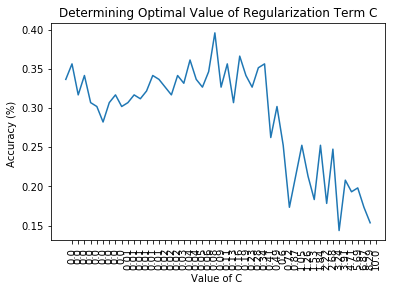

In [14]:
li = [np.arange(1,51)]
plt.plot(cost_accuracies)
plt.title("Determining Optimal Value of Regularization Term C")
plt.xlabel('Value of C ')
plt.ylabel('Accuracy (%) ')
costs_plot = np.around(costs,decimals=2)
plt.xticks(li[0],costs_plot, rotation=90)
plt.figure()

## Comparing our Best Logistic Regression Optimization Procedure to that of Scikit-Learn

In [28]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants


lr_sk = SKLogisticRegression(solver='lbfgs',class_weight='balanced',max_iter=500,C=0.002) 

lr_sk_accuracies = []
lr_sk_times = []
# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
#     print(X_train)
#     print(y_train)
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    st = time.time()
    lr_sk.fit(X_train,y_train)
    t = (time.time() -st)
    lr_sk_times.append(t)
    #print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
    yhat = lr_sk.predict(X_test)
 
    print("Iterations ",lr_sk.n_iter_)
    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    lr_sk_accuracies.append(acc)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

print(lr_sk_times)
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

Iterations  [220  46 157  37  56]
====Iteration 0  ====
accuracy 0.19801980198
confusion matrix
 [[ 0  0  0  0  0  0]
 [12  6  8  9  3  0]
 [12  4 10 10  4  0]
 [17 12 16 11 10  0]
 [ 7  3  6 10 13  0]
 [ 6  4  2  4  3  0]]
[0.29959988594055176]


20.663905143737793


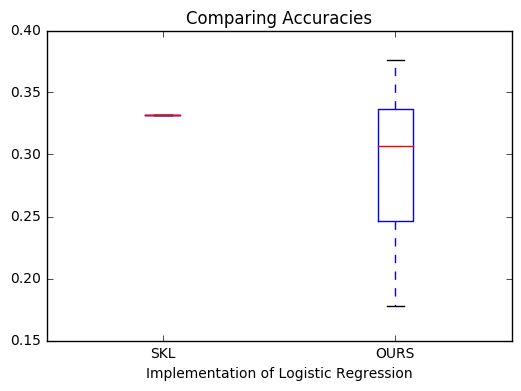

In [36]:
plt.boxplot([lr_sk_accuracies,lr_clf_accuracies])
plt.title("Comparing Accuracies")
plt.xlabel('Implementation of Logistic Regression')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()
print((time.time() -st)*100)
# ax = fig.add_subplot(111)


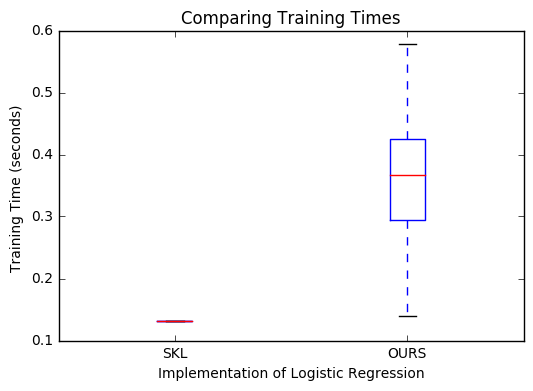

In [37]:
plt.boxplot([lr_sk_times,lr_clf_times])
plt.title("Comparing Training Times")
plt.xlabel('Implementation of Logistic Regression')
plt.ylabel('Training Time (seconds) ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()

## Analyzing which implementation of Logistic Regression would be best for our case

## Exceptional Work